# DM Linkedin Survey Data
### Section 0
    - Cleaning, grouping, data scraping, and writing functions to sort and assess our survey data
### Section 1
    - Ethnicity versus Exposure to LinkedIn
### Section 2
    - Majors and courses of study versus exposure to LinkedIn 
### Section 3
    - Majors and courses of study versus frequency of activity on LinkedIn
### Section 4
    - Count of respondents' occupation, current careers
### Section 5
    - Learning services vs. count, proportion, and exposure to LinkedIn Learning
### Section 6
    - Usage of News Services

## Intro
This notebook was created in order to analyze survey data from a survey regarding LinkedIn learning that was active among Berkeley students between 3/1 and 3/5. The resulting data was analyzed and inspected in order to:
- understand trends among Berkeley students and their learning habits
- elucidate association between certain demographic groups and exposure to LinkedIn Learning 
- inform future marketing campaigns by LinkedIn Learning to Berkeley Students

LinkedIn Learning has a partnership with the University of California, Berkeley that makes it free for use for all undergraduate students, and this project was intended to understand how best to present this resource to students such that it could be used by as many people and as meaningfully as possible. 

In [6]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 1.4)

In [84]:
linkedin = pd.read_csv("LinkedIn Survey (Responses) - Form Responses 1.csv")

## 0.0 - Cleaning, Grouping, Scraping Data

In [42]:
majorinterest = linkedin[['Do you have a LinkedIn profile?', 'What industry are you interested in pursuing? (check all that apply)', 'Major and Minor (i.e. Major: Economics, Minor: Data Science)']]

In [43]:
#Defined grabcountbykeyword: a function to extract rows relevant that contain a given keyword from a dataframe
def grabcountbykeyword(dataframe, keyword, searchcol, colofinterest, keywordlabel = "keywords found", 
                       interestlabel = "features found"):
    listforsearchcol = []
    listforcolofinterest = []
    dfstr = pd.Series(dataframe[searchcol].replace(np.nan, "none"), dtype = 'string')
    for i in np.arange(len(dfstr)):
        if dfstr[i].lower().find(keyword.lower()) != -1:
            listforsearchcol.append(keyword)
            listforcolofinterest.append(dataframe[colofinterest][i])
    returndict = {keywordlabel:listforsearchcol, interestlabel:listforcolofinterest}
    return pd.DataFrame(returndict)

In [44]:
#Defined zipdataframes: a function to stack dataframes of any length along 2 features 
def zipdataframes(dataframe, addedframe, searchlabel = "Major", featurelabel = "features"):
    majorslist = dataframe[searchlabel].tolist()
    featureslist = dataframe[featurelabel].tolist()
    majorslist.extend(addedframe[searchlabel].tolist())
    featureslist.extend(addedframe[featurelabel].tolist())
    ddict = {searchlabel: majorslist, featurelabel: featureslist}
    return pd.DataFrame(ddict)

In [45]:
#Defined groupandresize: a function to reshape and group a matrix of individual entries along the lines of a given 
#feature
def groupandresize(dataframe, searchcol, colofinterest):
    return dataframe.groupby([searchcol, colofinterest]).size().reset_index()

In [46]:
#Use case of a grabandconstruct function to test efficiency and validity
majorframe = grabcountbykeyword(majorinterest, "Business", 'Major and Minor (i.e. Major: Economics, Minor: Data Science)', 
                  'Do you have a LinkedIn profile?', "Major", "On linkedin")
majorlist = ["econ", "media", "bio", "physic", "film", "poli", "psych", "data", 
             "math", "comp", "chem"]
for major in majorlist:
    majorframe = zipdataframes(majorframe, grabcountbykeyword(majorinterest, major, 
                    'Major and Minor (i.e. Major: Economics, Minor: Data Science)', 
                  'Do you have a LinkedIn profile?', "Major", "On linkedin"), "Major", "On linkedin")

In [47]:
#Defined grabandconstruct: a function that leverages grabcountbykeyword to iterate through a keywordlist, a container
# of keywords of interest, and then zips the resulting frames together to return one dataframe of desired entries
def grabandconstruct(dataframe, keywordlist, searchcol, colofinterest, keywordlabel, interestlabel):
    returnframe = grabcountbykeyword(dataframe, keywordlist[0], searchcol, colofinterest, keywordlabel, interestlabel)
    for keyword in keywordlist[1:]:
        returnframe = zipdataframes(returnframe, 
                                   grabcountbykeyword(dataframe, keyword, searchcol, colofinterest, 
                                                      keywordlabel, interestlabel), keywordlabel, interestlabel)
    return returnframe

In [48]:
#Defined proportionbuilder: a function to take in a dataframe and column and take proportions of yes/no answers
# when every other row collects the same data and only sums over sets of 2 rows
def proportionbuilder(dataframe, colindex):
    counts = dataframe[colindex]
    totals = []
    subtotal = 0
    count = 0
    for curr in counts:
        if count%2==0 and count > 0:
            totals.append(subtotal)
            totals.append(subtotal)
            subtotal = 0
        subtotal += curr
        count += 1
    totals.append(subtotal)
    totals.append(subtotal)
    return dataframe[colindex] / totals

In [49]:
collectedmajors = groupandresize(majorframe, "Major", "On linkedin")

In [50]:
#adds a proportion to the collectmajors dataframe
collectedmajors['Proportion on linkedin'] = proportionbuilder(collectedmajors, 0)

In [51]:
#subsets the survey data for just interests, majors, and frequency of use of linkedin
linkedinusage = linkedin[['What industry are you interested in pursuing? (check all that apply)', 'Major and Minor (i.e. Major: Economics, Minor: Data Science)', 'How often do you use LinkedIn?']]                       
                   

In [52]:
#creates a list of prefixes that correspond to majors entered by responders, builds a dataframe of those majors / 
# minors against frequency of use of linkedin
majorlist2 = ["business", "econ", "media", "bio", "physic", "film", "poli", "psych", "data", 
             "math", "comp", "chem"]
usagesorted = grabandconstruct(linkedinusage, majorlist2, 
                               'Major and Minor (i.e. Major: Economics, Minor: Data Science)',
                               'How often do you use LinkedIn?', 'Major',
                              'How often do you use LinkedIn?')

In [53]:
#groups that dataframe by Major (which truly represents major and minor) against response to linkedin usage
usagedf = groupandresize(usagesorted, 'Major', 
                        'How often do you use LinkedIn?')

In [54]:
# counts events of each response to whether responders are students, employed, or other, and then groups "other"
# responses as necessary
linkedin.groupby(['Which of the following do you identify with?']).size().reset_index()
collectiondict = {'Which of the following do you identify with?' : ['Employed', 'Job Seeker', 
                                                                   'Student', 'Student and Employed'], 
                 'Count': [23, 34, 333, 5]}
identitygrouped = pd.DataFrame(collectiondict)

In [55]:
#subsets survey data for usage of other services and if they've been exposed to linkedin learning
usedf = linkedin[['Which of these do you use (check all that apply)?', 'Have you heard of LinkedIn Learning?']]

In [56]:
#breaking it all down, first we make a list of the possible responses
useoptions = ['Coursera', 'Khan Academy', 'LinkedIn Learning', 'Masterclass', 'Udemy', 'Udacity']

#then construct a dataframe of each appearance of a service and if they've heard of linkedin
justuse = grabandconstruct(usedf, useoptions,
                                 'Which of these do you use (check all that apply)?',
                                 'Have you heard of LinkedIn Learning?',
                                 'Learning Service Used', 'Have you heard of LinkedIn Learning?')
interestbyuse = groupandresize(justuse, 'Learning Service Used',
                              'Have you heard of LinkedIn Learning?')
interestbyuse = interestbyuse.drop([8])

#then create a properly grouped dataframe by user of a service and if they've heard of linkedin
interestbyuse["Proportion that have heard of Linkedin Learning"] = proportionbuilder(interestbyuse, 0)

#and create a separate set for just counts of service users
justuse = justuse.groupby(['Learning Service Used']).count().reset_index()

In [57]:
#building dataframe of ethnicity against exposure to linkedin learning
heardnethnicity = linkedin[['Have you heard of LinkedIn Learning?', 'Which of the following best describes you?']]
groupedeth = heardnethnicity.groupby(['Which of the following best describes you?', 'Have you heard of LinkedIn Learning?']).size()
groupedeth = groupedeth.reset_index()

In [58]:
#adds a proportion column to the dataframe of ethnicity versus exposure to linkedin learning
groupedeth['proportion totals'] = proportionbuilder(groupedeth, 0)

In [59]:
usedf['Which of these do you use (check all that apply)?'][1]

'Khan Academy'

In [60]:
# counts occurences of a second keyword out of total occurences of a given keyword
def keywordcorrelation(keyword1, keyword2, dataframe, searchcol):
    keyword1appearances = 0
    keywordoverlap = 0
    dfstr = pd.Series(dataframe[searchcol].replace(np.nan, "none"), dtype = 'string')
    for i in np.arange(len(dfstr)):
        if dfstr[i].lower().find(keyword1.lower()) != -1:
            keyword1appearances += 1
            if dfstr[i].lower().find(keyword2.lower()) != -1:
                keywordoverlap += 1
    return (keywordoverlap, keyword1appearances, keywordoverlap / keyword1appearances)

In [61]:
# Counting individual responses to the question of platforms for school related news
news = linkedin[['Which of the these platforms do you use to get the most school-related news?']]
responses = ['Email', 'Instagram', 'Facebook', 'Slack', 'LinkedIn', 'Tikok']
splitnews = grabandconstruct(news, responses,
                 'Which of the these platforms do you use to get the most school-related news?',
                 'Which of the these platforms do you use to get the most school-related news?',
                 'Platform Used', 'All platforms Used')
groupednews = splitnews.groupby(['Platform Used']).count().reset_index()


In [62]:
# School related news versus exposure to LinkedIn Learning
newsnexposure = linkedin[['Which of the these platforms do you use to get the most school-related news?', 
                         'Have you heard of LinkedIn Learning?']]
newsexpgrouped = grabandconstruct(newsnexposure, responses,
                 'Which of the these platforms do you use to get the most school-related news?',
                 'Have you heard of LinkedIn Learning?',
                 'Platform Used', 'Have you heard of LinkedIn Learning?')
newsplatforms = groupandresize(newsexpgrouped, 'Platform Used', 'Have you heard of LinkedIn Learning?')
newsplatforms['Proportion exposed to LinkedIn Learning'] = proportionbuilder(newsplatforms, 0)

In [63]:
# changed the axes to proportion instead of count out of curiosity
groupednews['Proportion of Respondees'] = groupednews['All platforms Used'] / len(groupednews)

In [94]:
freshmen = linkedin[linkedin['Year'] == "Freshman"]
sophomores = linkedin[linkedin['Year'] == "Sophomore"]
juniors = linkedin[linkedin['Year'] == "Junior"]
seniors = linkedin[linkedin['Year'] == "Senior"]

exposurebyyear = groupandresize(linkedin[['Year', 'Have you heard of LinkedIn Learning?']], 'Year', 'Have you heard of LinkedIn Learning?')
freshmen[['Year', 'Have you heard of LinkedIn Learning?']]
majorslist = freshmen['Year'].tolist()
featureslist = freshmen['Have you heard of LinkedIn Learning?'].tolist()
majorslist.extend(sophomores['Year'].tolist())
featureslist.extend(sophomores['Have you heard of LinkedIn Learning?'].tolist())
majorslist.extend(juniors['Year'].tolist())
featureslist.extend(juniors['Have you heard of LinkedIn Learning?'].tolist())
majorslist.extend(seniors['Year'].tolist())
featureslist.extend(seniors['Have you heard of LinkedIn Learning?'].tolist())
yeardict = {"Year":majorslist, "Have you heard of LinkedIn Learning?":featureslist}
byyear = pd.DataFrame(yeardict)
byyear = groupandresize(byyear, "Year", "Have you heard of LinkedIn Learning?")

## 1.0 Does Ethnicity Affect Exposure to Linkedin Learning?

### 1.1 - Have You Heard of Linkedin? By count

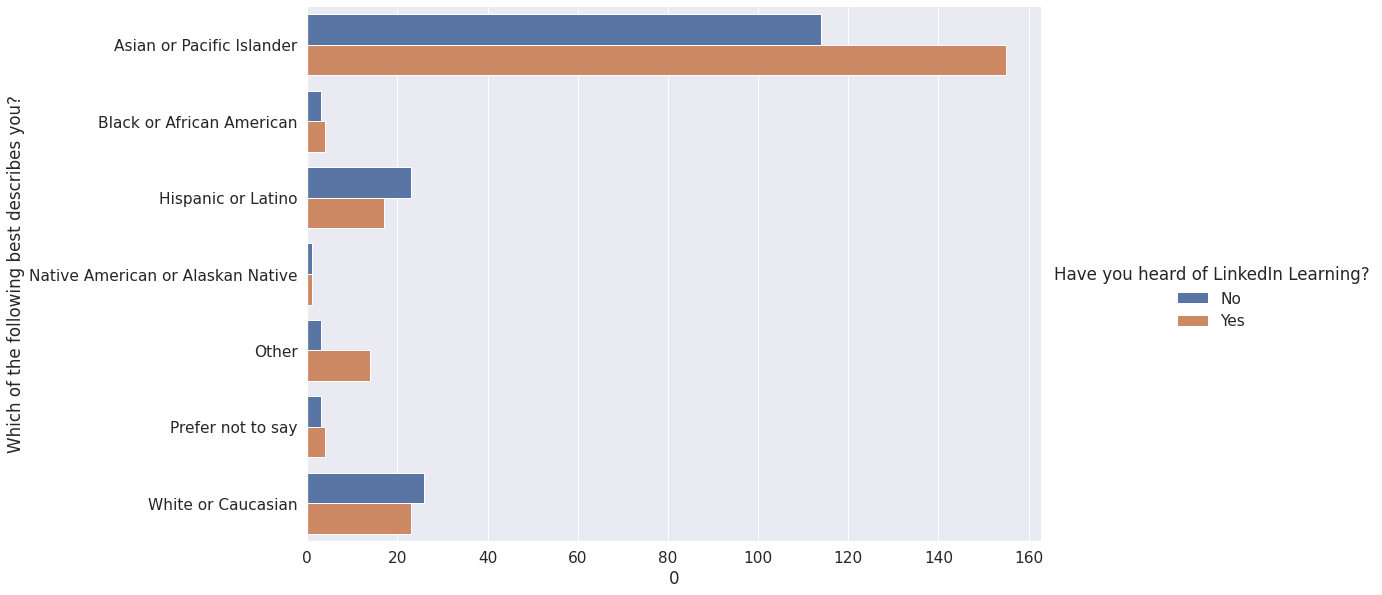

In [64]:
sns.color_palette("bright")
sns.catplot(y = 'Which of the following best describes you?', x = 0, hue = 'Have you heard of LinkedIn Learning?', 
            data = groupedeth, kind = 'bar', height=8.27, aspect=15.7/8.27)

### 1.2 - Have You Heard of Linkedin? By proportion

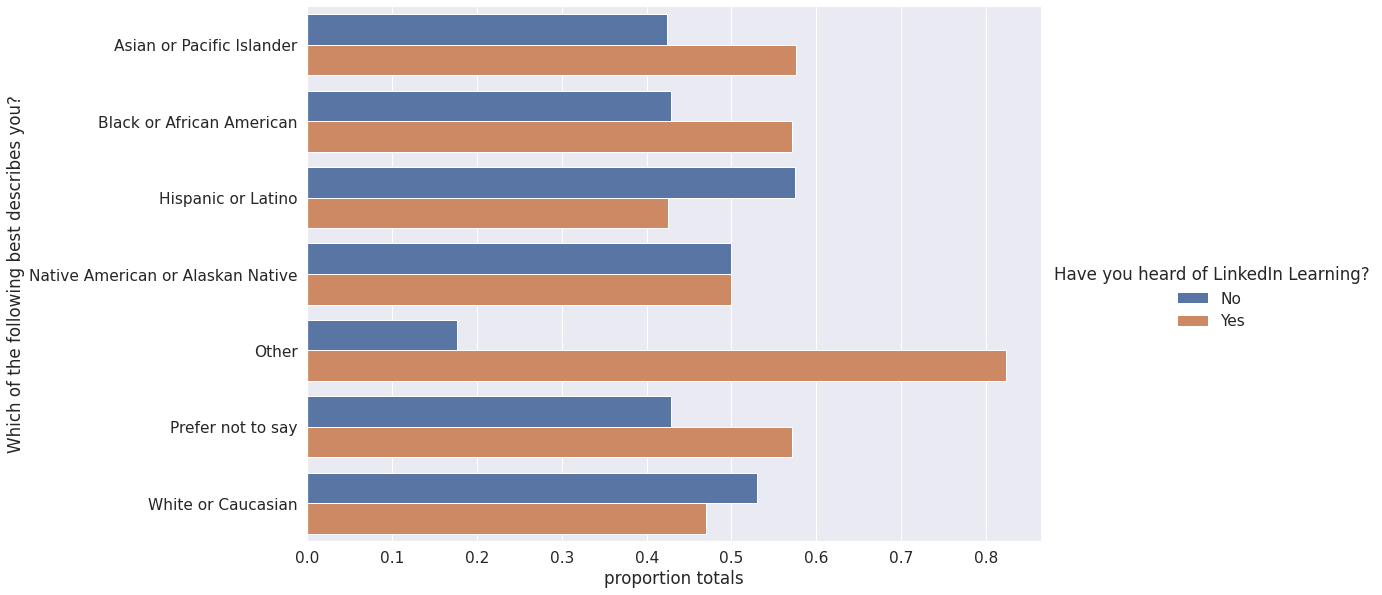

In [65]:
sns.color_palette("bright")
sns.catplot(y = 'Which of the following best describes you?', x = 'proportion totals', hue = 'Have you heard of LinkedIn Learning?', 
            data = groupedeth, kind = 'bar', height=8.27, aspect=15.7/8.27)

### Thoughts:
* Visibly, the ethnic groups of Hispanic or Latino and White or Caucasian have much less exposure to LinkedIn learning compared to Asian or Pacific Islander and Black or African American. 
* of these groups, since the Asian or Pacific Islander respondees have the largest representation groups, the data seems only to be accurate in reflecting the three largest groups (n > 20), Asian or Pacific Islander, Hispanic or Latino, and White or Caucasian

## 2.0 - What Majors and Minors are most interested in using linkedin?

### 2.1 - Are You On Linkedin? By major, by count

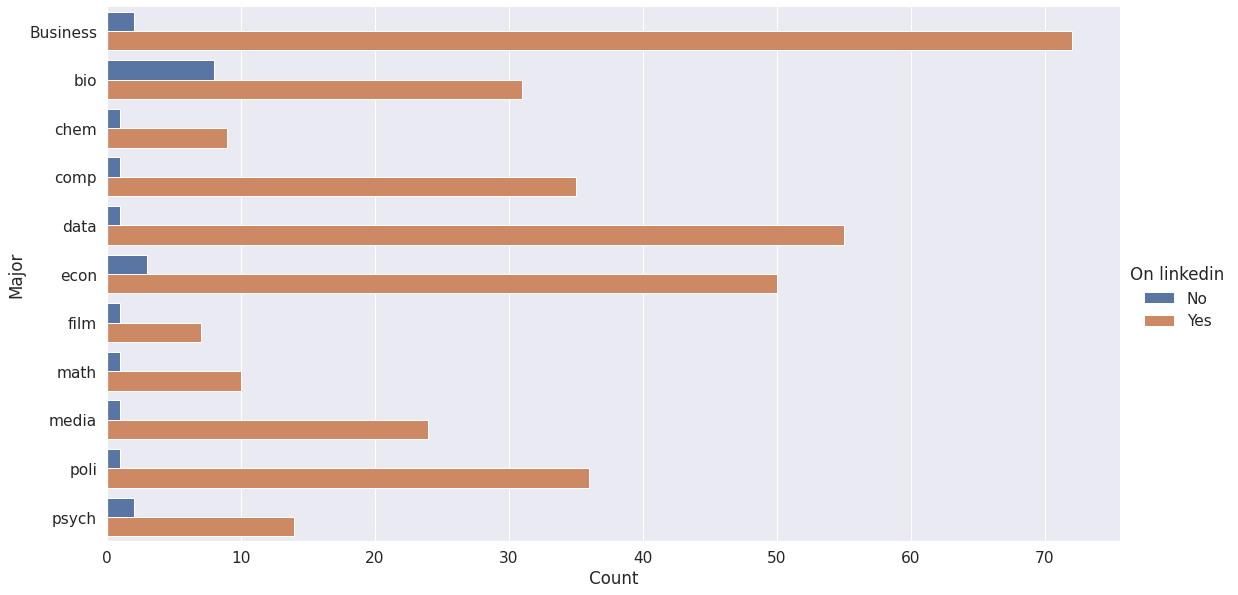

In [66]:
sns.color_palette("bright")
sns.catplot(y = 'Major', x = 0, hue = 'On linkedin', 
            data = collectedmajors, kind = 'bar', height=8.27, aspect=15.7/8.27)
plt.xlabel("Count")
plt.show()

### 2.2 - Are You On Linkedin? By major, by proportion

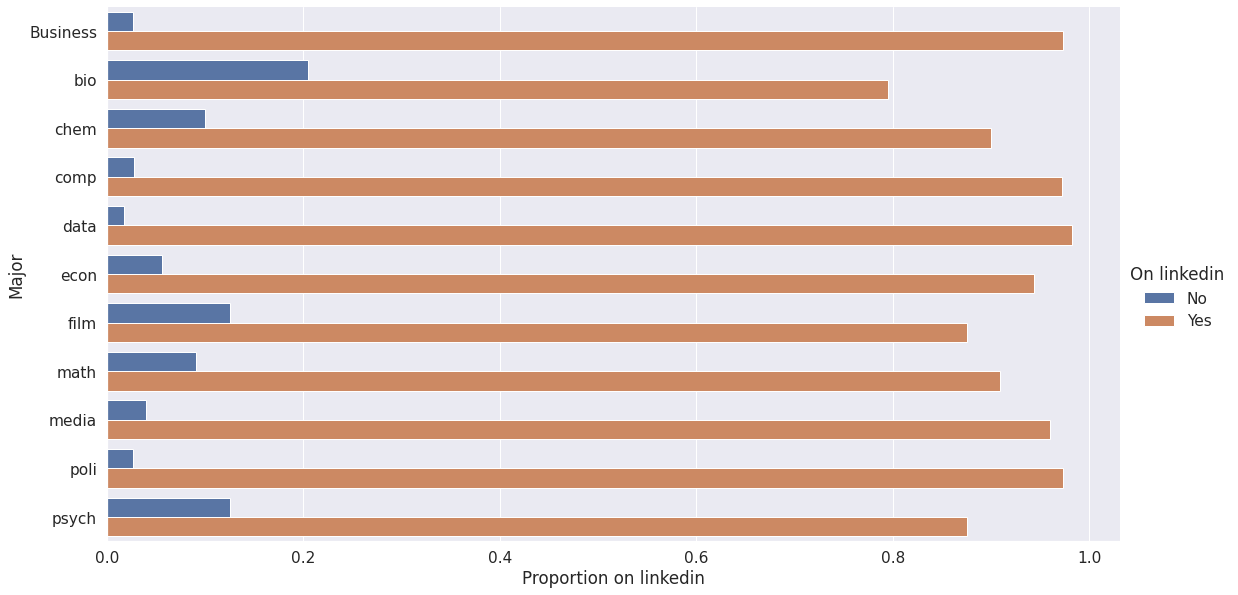

In [67]:
sns.color_palette("bright")
sns.catplot(y = 'Major', x = "Proportion on linkedin", hue = 'On linkedin', 
            data = collectedmajors, kind = 'bar', height=8.27, aspect=15.7/8.27)

### Thoughts:
* Very notably, business majors, econ majors, media studies majors, data / computer science, and political science majors have a much higher percentage of LinkedIn, especially compared to Bio, Chem, and Psych majors.
* To that extent, the "physical sciences" seem to be notably less present on Linkedin when compared to business and technical majors
* Perhaps this is an important consideration for the campaign, since business industry and technical majors seem much more present on LinkedIn

## 3.0 - What majors/minors/industries are already using LinkedIn?

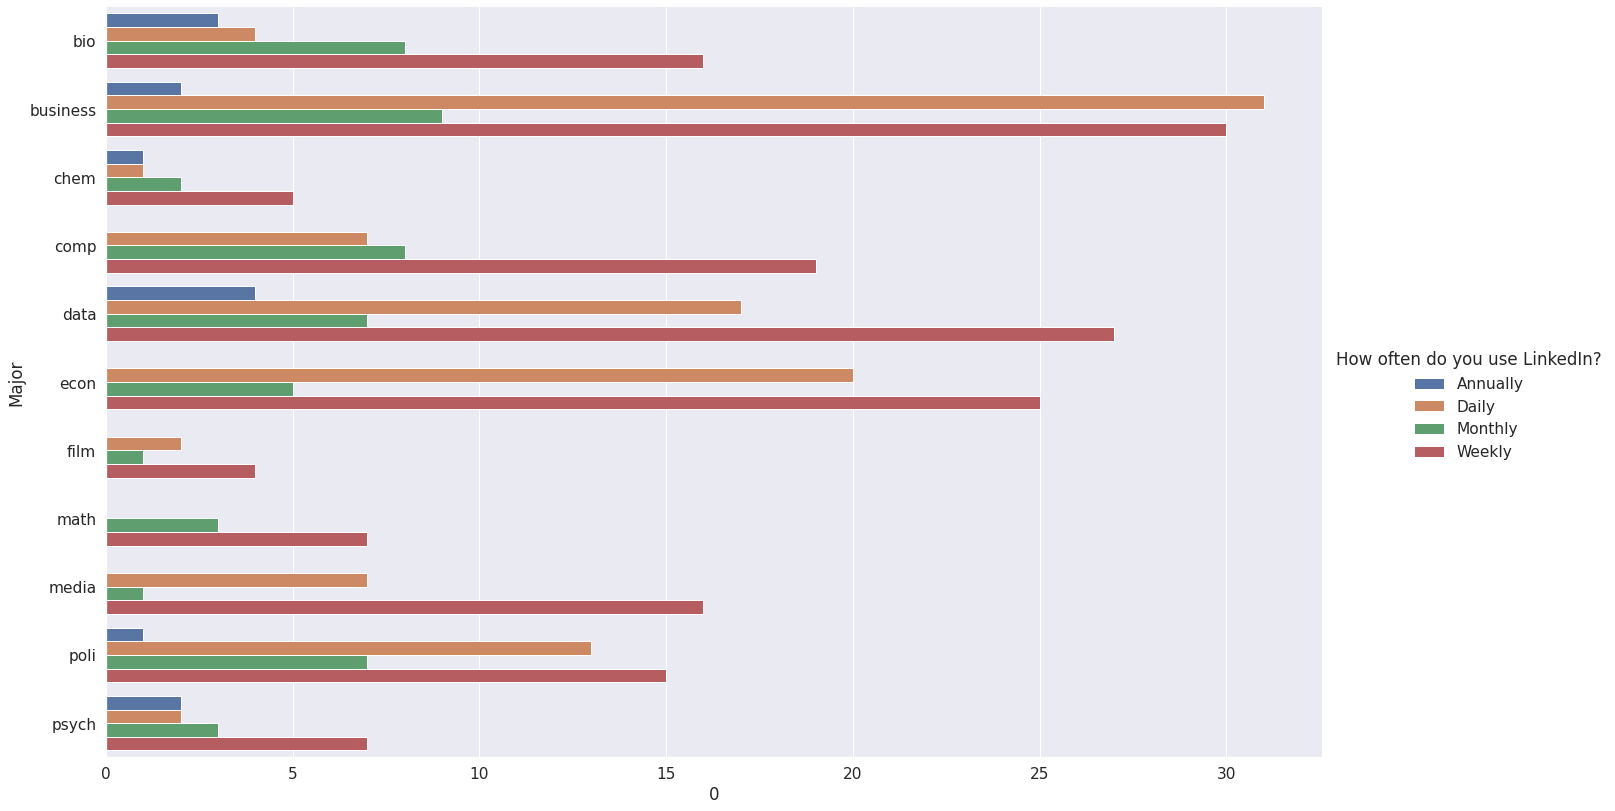

In [68]:
sns.color_palette("bright")
sns.catplot(y = 'Major', x = 0, hue = 'How often do you use LinkedIn?', 
            data = usagedf, kind = 'bar', height=11.27, aspect=18.7/11.27)

### Thoughts:
* Here, the trends from the above graph are even more exacerbated:
* Among the **"Business, Industry, and Tech"** majors:
    - Business majors now can be seen to have a significant proportion above any other major that use LinkedIn daily, and *almost all business majors use LinkedIn at least weekly, but most use it daily*
    - Econ follows that trend closely, with only a somewhat smaller proportion using LinkedIn every day, but still with most responses pointing to weekly usage
    - Now computer and data science majors can be seen to differ in behavior from the above two majors, as *the majority use LinkedIn only weekly, and have a much higher percentage of only monthly users*
* Among the **"Physical Science"** majors:
    - Despite a lower percentage on LinkedIn, a sizable number of biology, chemistry, and psychology majors are on LinkedIn weekly, representing a closer trend to other majors compared to the above graphs

## 4.0 - Find a way to categorize “Which of the following do you identify with” because there are some “other” answers


Others include: Student, Employed, Employed and student, Employed but also job seeker, Employed student, Job seeker, Kelli, Student & Employed

## 4.1 - Count for Identity among Students, Employed, Job Seekers

<AxesSubplot:xlabel='Count', ylabel='Which of the following do you identify with?'>

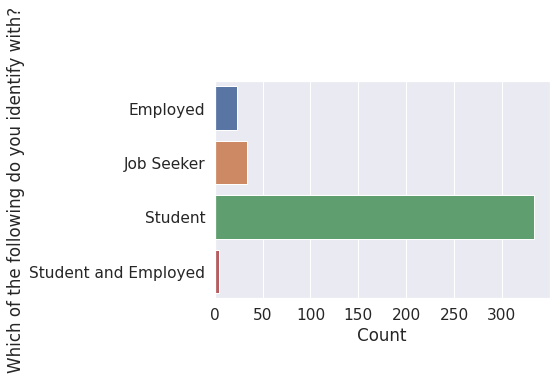

In [69]:
sns.barplot(y = 'Which of the following do you identify with?', x = 'Count',
            data = identitygrouped)

### Thoughts:
* Here, this data doesn't seem particularly useful to me, as the way the question was posed seemed to have most people respond strictly with one of the categories and dissuaded people from responding with several answers

## 5.0 - For “Which of these do you use (check all that apply)” what is the distribution?

Is there a difference between Interest vs Use in LinkedIn Learning?


## 5.1 - Learning Services by User Count

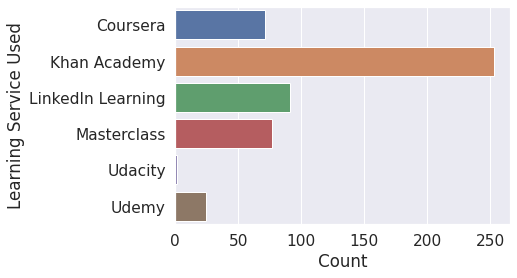

In [70]:
sns.barplot(y = 'Learning Service Used', x = 'Have you heard of LinkedIn Learning?',
            data = justuse)
plt.xlabel("Count")
plt.show()

## 5.2 - Learning Services vs. Knowledge of Linkedin Learning, by count

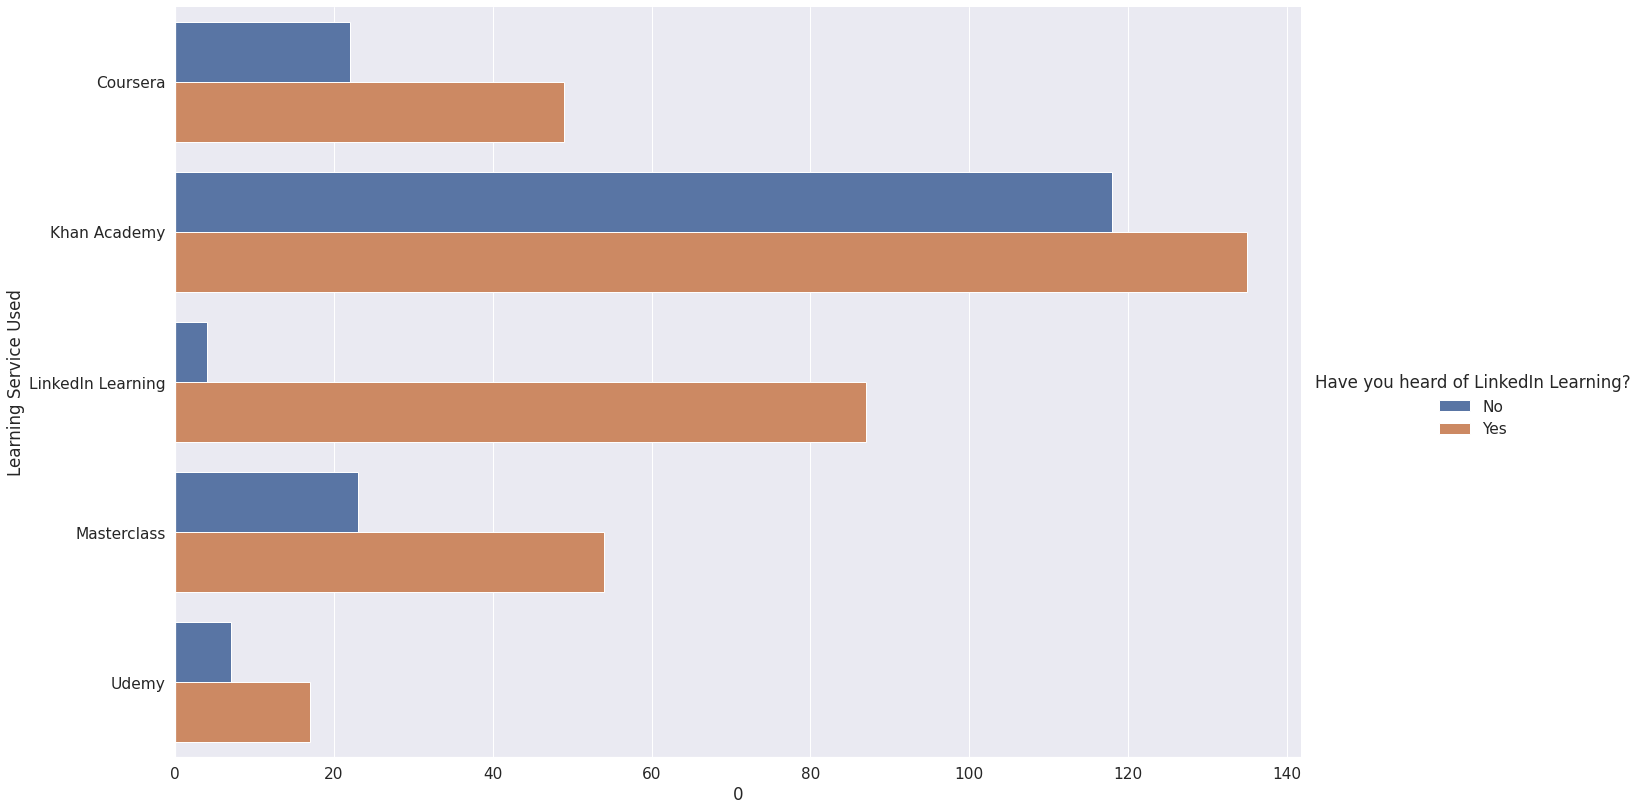

In [71]:
sns.color_palette("bright")
sns.catplot(y = 'Learning Service Used', x = 0, hue = 'Have you heard of LinkedIn Learning?', 
            data = interestbyuse, kind = 'bar', height=11.27, aspect=18.7/11.27)

## 5.3 - Learning Services vs. Knowledge of Linkedin Learning, by proportion

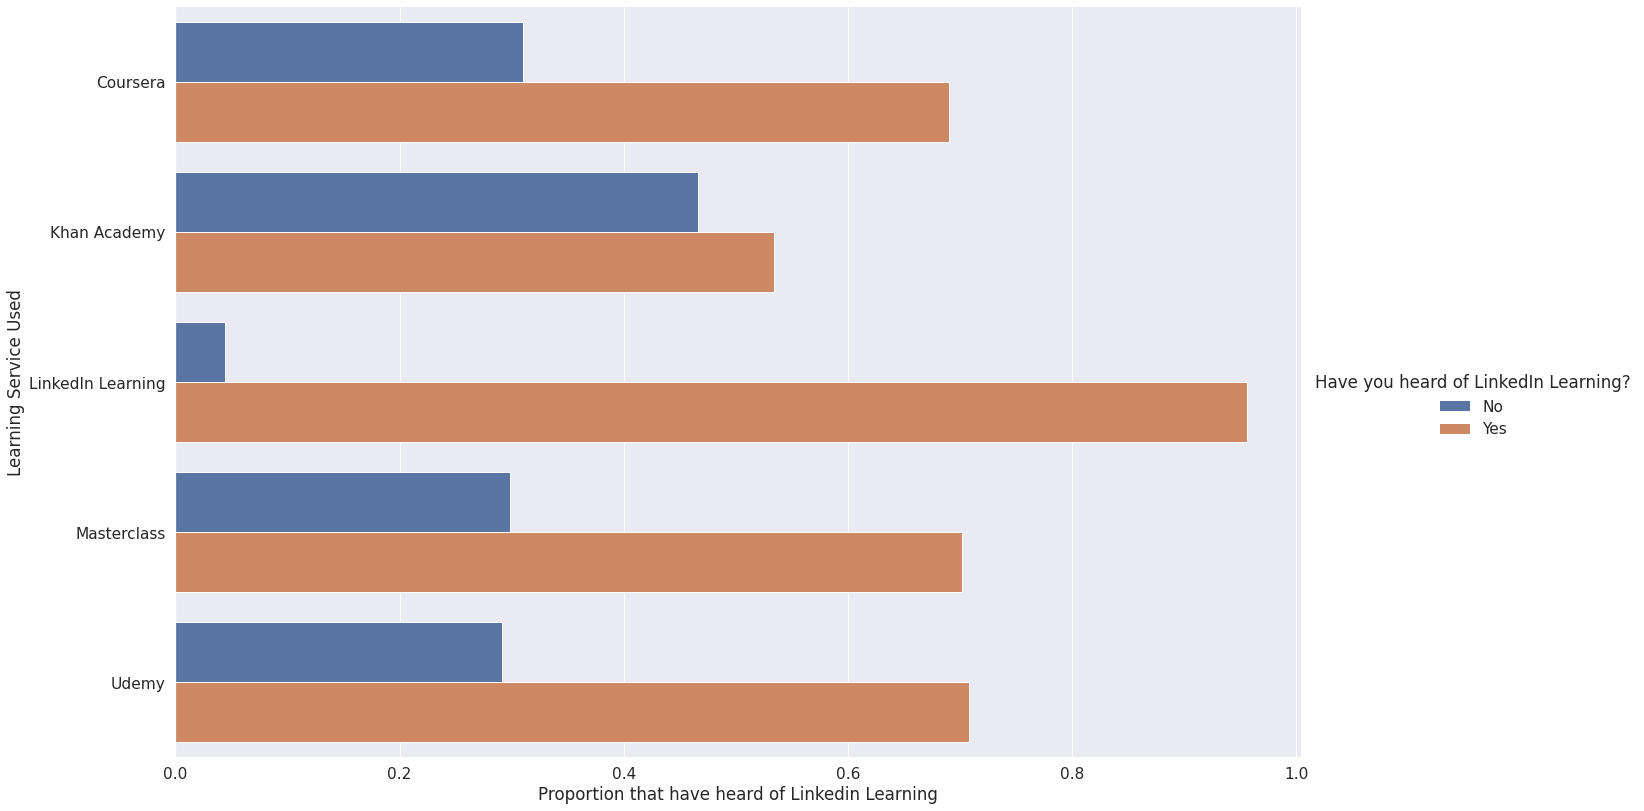

In [72]:
sns.color_palette("bright")
sns.catplot(y = 'Learning Service Used', x = "Proportion that have heard of Linkedin Learning",
            hue = 'Have you heard of LinkedIn Learning?', data = interestbyuse, 
            kind = 'bar', height=11.27, aspect=18.7/11.27)

### Thoughts:
* A majority of respondants use Khan Academy, something we'd previously noted but now can explore in more detail
* Trends among Khan Academy users:
    - A majority have heard of LinkedIn Learning, but still more than 40% of the 250+ Khan Academy users have not heard of LinkedIn learning
    - a majority of Khan Academy users also use another learning service, and a fairly small proportion also use LinkedIn Learning
        - however, as shown below, **the number of overlapping users between Khan Academy and LinkedIn Learning, Coursera, and Masterclass are very similar**
        - seen below: there are 253 Khan Academy users, with 50 overlapping with LinkedIn Learning, 46 overlapping with Masterclass, and 42 overlapping with Coursera
        - thus 19.76% use both KA and LL, 18.18% use both KA and MC, and 16.6% use both KA and Coursera
* Trends among other users:
    - Compared to Khan Academy, users of other learning services seem to be more knowledgeable about other learning services, with most having more than 70% of respondents that had heard of LinkedIn Learning
    - A Higher proportion of people use LinkedIn Learning than I anticipated - just over a quarter out of our 391 respondents have used LinkedIn Learning

In [73]:
linkedintotal, khantotal, propll = keywordcorrelation('Khan Academy', 'LinkedIn Learning', usedf, 'Which of these do you use (check all that apply)?')
mctotal, khantotal2, propmc = keywordcorrelation('Khan Academy', 'Masterclass', usedf, 'Which of these do you use (check all that apply)?')
courseratotal, khantotal3, propcs = keywordcorrelation('Khan Academy', 'Coursera', usedf, 'Which of these do you use (check all that apply)?')

In [74]:
print("Total Khan Academy Users: ", khantotal)
print("LinkedIn Learning Users of those Users: ", linkedintotal)
print("Proportion that use both KA and LL: ", propll)
print("Masterclass Users of those Users: ", mctotal)
print("Proportion that use both KA and MC: ", propmc)
print("Masterclass Users of those Users: ", courseratotal)
print("Proportion that use both KA and CS: ", propcs)

Total Khan Academy Users:  253
LinkedIn Learning Users of those Users:  50
Proportion that use both KA and LL:  0.1976284584980237
Masterclass Users of those Users:  46
Proportion that use both KA and MC:  0.18181818181818182
Masterclass Users of those Users:  42
Proportion that use both KA and CS:  0.16600790513833993


## 6.0 - Which of these platforms do you use to get the most school-related news?


### 6.1 - Distribution of Platforms Used

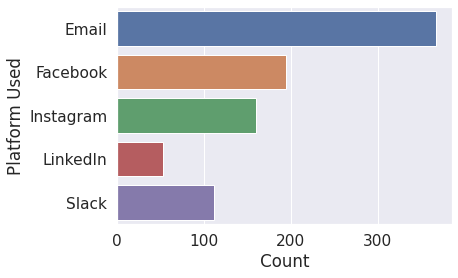

In [75]:
sns.barplot(y = 'Platform Used', x = 'All platforms Used',
            data = groupednews)
plt.xlabel("Count")
plt.show()

### 6.2 - Distribution of Platforms Used by Proportion

<AxesSubplot:xlabel='Proportion of Respondees', ylabel='Platform Used'>

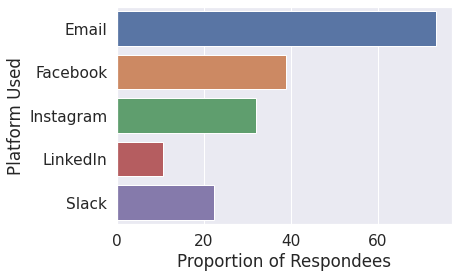

In [76]:
sns.barplot(y = 'Platform Used', x = 'Proportion of Respondees',
            data = groupednews)

### 6.3 - Platform Use vs. Exposure to LinkedIn Learning (count)

Text(0.5, 14.143999999999991, 'Count')

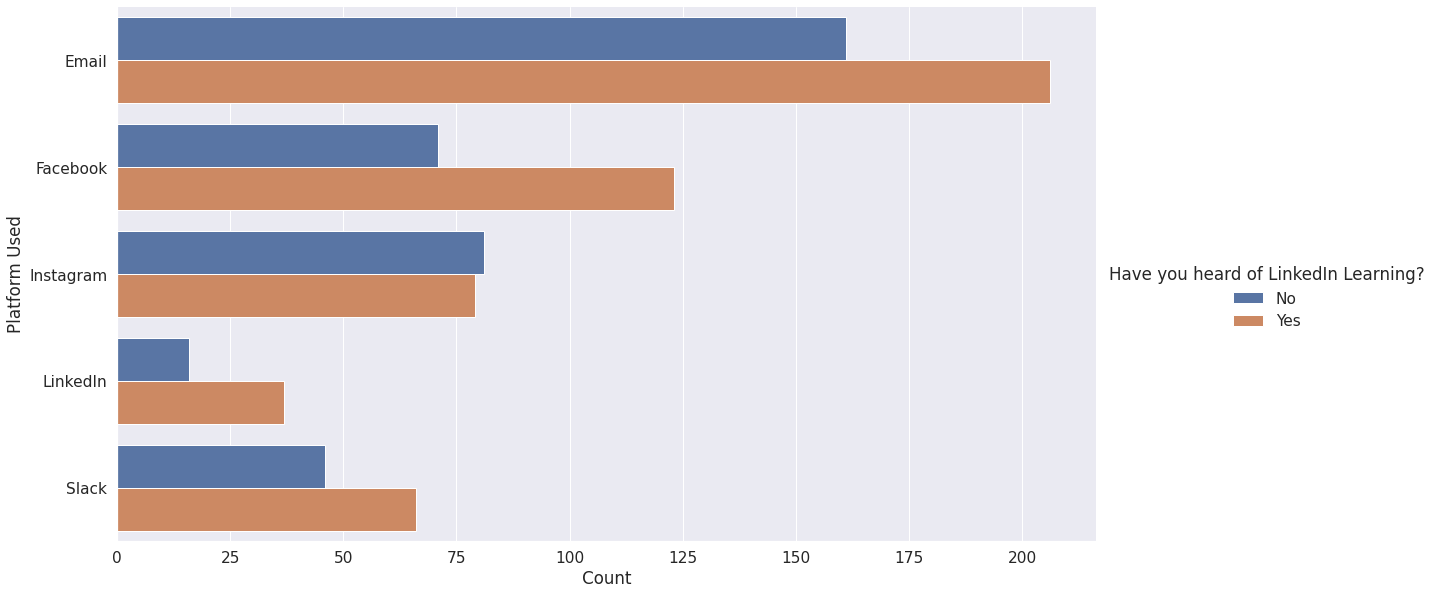

In [77]:
sns.color_palette("bright")
sns.catplot(y = 'Platform Used', x = 0, hue = 'Have you heard of LinkedIn Learning?', 
            data = newsplatforms, kind = 'bar', height=8.27, aspect=15.7/8.27)
plt.xlabel("Count")

### 6.4 - Platform Use vs. Exposure to LinkedIn Learning (proportion)

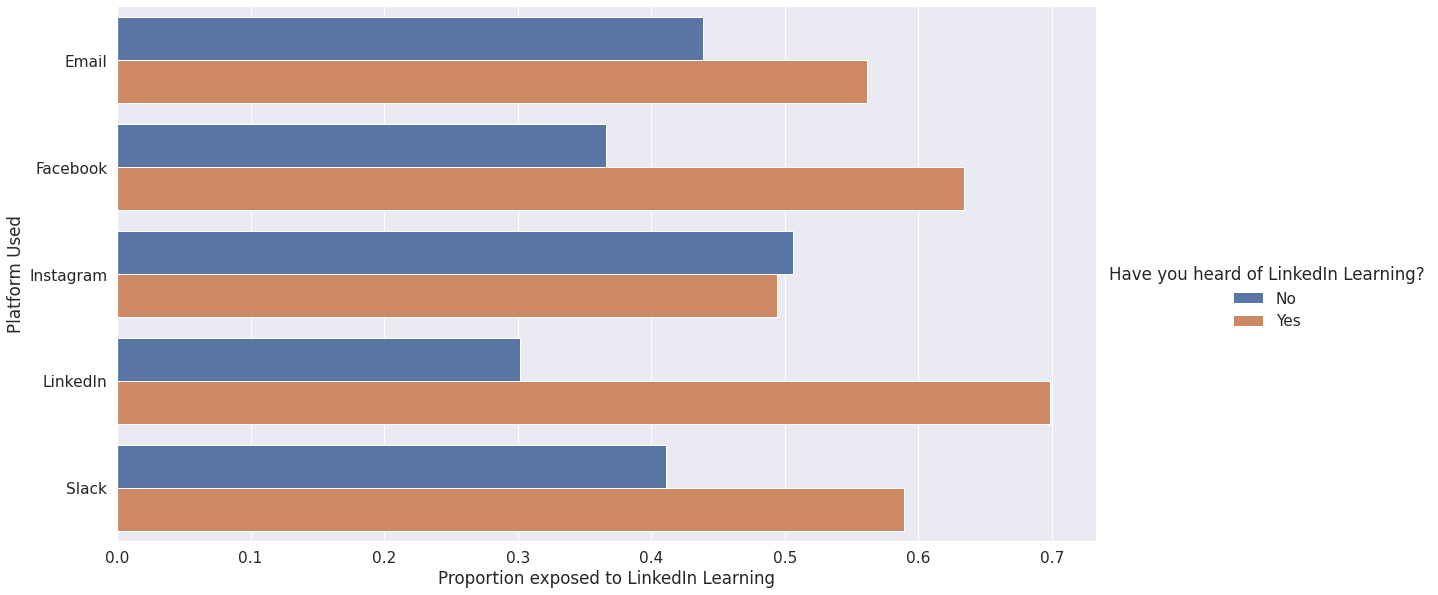

In [78]:
sns.color_palette("bright")
sns.catplot(y = 'Platform Used', x = 'Proportion exposed to LinkedIn Learning', hue = 'Have you heard of LinkedIn Learning?', 
            data = newsplatforms, kind = 'bar', height=8.27, aspect=15.7/8.27)

### Thoughts:
* The most popular answer given was email, which makes sense especially in a COVID semester when most correspondence through Berkeley is delivered by email
* Beyond that, Instagram and Facebook are close in 2nd and 3rd most used, showing potential to deliver meaningful promotion through key social media channels
* Though it was given as an option, NOBODY put Tiktok as a key news platform
* Interestingly enough Instagram is the only platform where a majority of people had never even heard of LinkedIn Learning
* LinkedIn users had the most exposure to LinkedIn Learning, as expected
    - But still a sizable proportion had not heard of LinkedIn Learning
    - However, the number of respondees that checked LinkedIn is smaller than that of most other categories


## 7.0 - How does Year in School Impact Exposure to LinkedIn Learning?

### 7.1 - Year vs. Exposure to LinkedIn Learning (count)

Text(0.5, 14.143999999999991, 'Count')

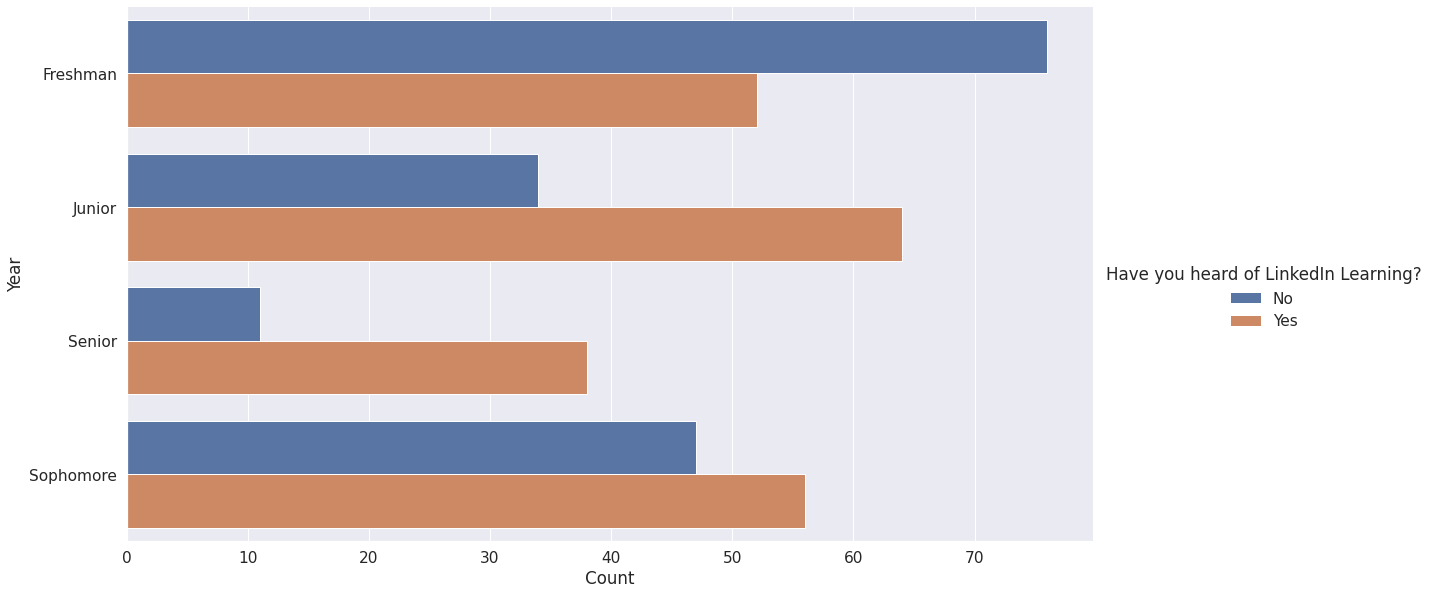

In [96]:
sns.color_palette("bright")
sns.catplot(y = 'Year', x = 0, hue = 'Have you heard of LinkedIn Learning?', 
            data = byyear, kind = 'bar', height=8.27, aspect=15.7/8.27)
plt.xlabel("Count")

In [97]:
byyear['Proportion Exposed'] = proportionbuilder(byyear, 0)

### 7.2 - Year vs. Exposure to LinkedIn Learning (proportion)

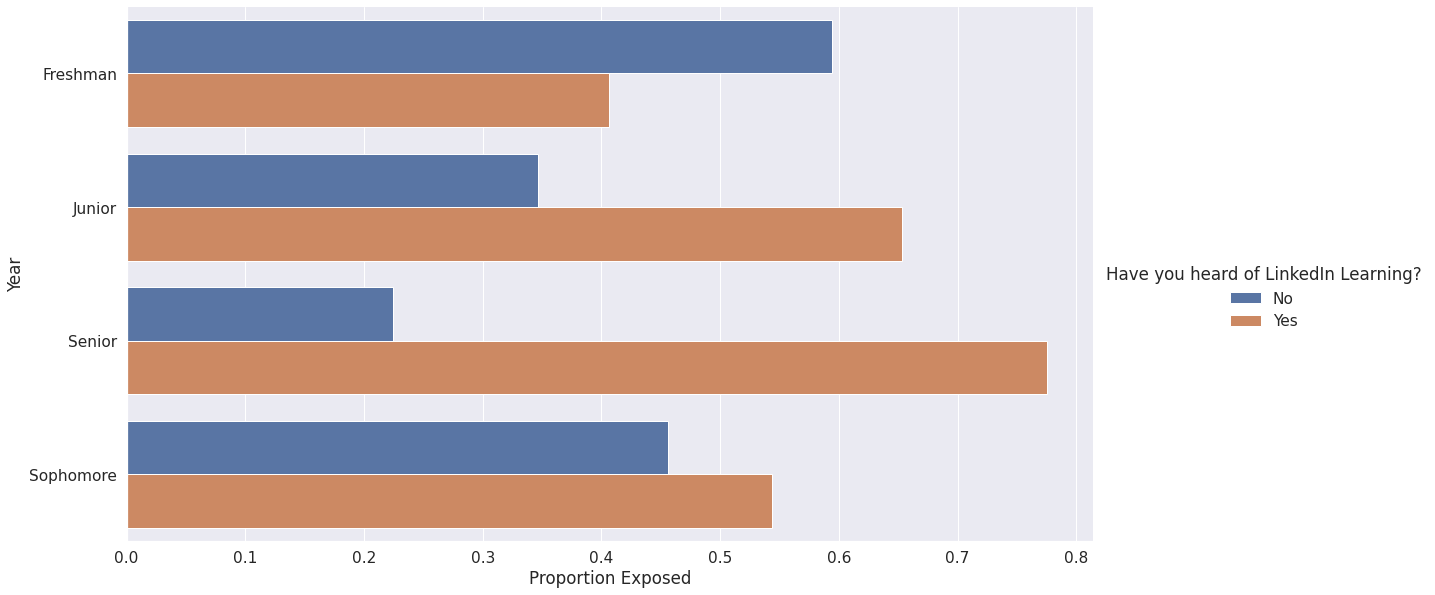

In [99]:
sns.color_palette("bright")
sns.catplot(y = 'Year', x = 'Proportion Exposed', hue = 'Have you heard of LinkedIn Learning?', 
            data = byyear, kind = 'bar', height=8.27, aspect=15.7/8.27)

### Thoughts:
* There appears to be a quite linear trend of exposure versus year in school
    - This is a significant result - since LL is free for all four years of college, underclassmen being less exposed to LL creates a perfect opportunity for early adoption among these younger groups
* We also had the most respondents in the Freshman group, further solidifying the validity of this result that Freshman truly have the least exposure to LL
